# Model: Predicting MLS Selling Success

## Summary

In this notebook, my objective is to predict whether or not a listed home will sell. I took the cleaned MLS data and added a column regarding the flood likelihood depending on which zip code the home is located in, using a binary logistic regression model.

## Import

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import copy

pd.set_option('display.max_columns', None) # Displays all columns

from scipy.stats import kurtosis, skew

import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
def view(dataframe, n: int=3):
    """Displays the preview of the first and last rows of the dataframe
    Args:
        dataframe: The dataframe being called
        n: Number of rows to select for preview. Defaults to 3.
    Returns:
        The first n and the last n rows of the dataframe
    """

    with pd.option_context('display.max_rows',n*2):
        display(dataframe)

In [3]:
def rename(dataframe, column, original, rename):
    """Replaces all instances of a specific string in one column with a new string
    Args:
        dataframe: The dataframe being called
        column: The column being called
        oringal: Original string to be replaced
        rename: New string to replace original string
    """

    dataframe.loc[dataframe[column].str.contains(original), column] = str(rename)
    return

In [4]:
def stats(dataframe, column):
    """Generates single column stats and boxplot
    Args:
        dataframe: The dataframe being called
        column: The column being called
    Returns:
        Descriptive statistics and boxplot of the column
    """
    
    print(f'Data type: {dataframe[column].dtype}')
    print(f'Count: {dataframe[column].shape[0]}')
    print(f'Number of Unique Values: {dataframe[column].nunique()}')
    print(f'Number of nulls: {dataframe[column].isna().sum()} - {round(100*dataframe[column].isna().sum()/len(dataframe),2)}%')
    print()
    print(f'Mean: {dataframe[column].mean()}')
    print(f'Minimum: {dataframe[column].min()}')
    print(f'Lower Quartile: {dataframe[column].quantile(.25)}')
    print(f'Median: {dataframe[column].quantile(.5)}')
    print(f'Upper Quartile: {dataframe[column].quantile(.75)}')
    print(f'Maximum: {dataframe[column].max()}')

    plt.figure(figsize=(10,1))
    plt.title(f'Boxplot Distrubution of {column}', fontsize=14, fontweight='bold')
    ax = sns.boxplot(x=dataframe[column])
    plt.xlabel(column, fontsize=13, fontweight='bold')
    plt.show()

In [5]:
def preview_cols(dataframe):
    """Generates quick preview of each column in the dataframe
    Args:
        dataframe: The dataframe being called
    Returns:
        Datatype
        Number of unique values
        Number of nulls
        Descriptive statistics and boxplot for numeric columns
        The first n and the last n values of the column
        Visualization of most frequent values
        
    """
    
    for i in dataframe.columns:
        print(i.upper())
        print()
        if (dataframe[i].dtype=='int' or dataframe[i].dtype=='float'): 
            print(stats(dataframe,i))
        else: 
            print(f'Data type: {dataframe[i].dtype}')
            print(f'Number of unique values: {dataframe[i].nunique()}')
            print(f'Number of nulls: {dataframe[i].isna().sum()} - {round(100*dataframe[i].isna().sum()/len(dataframe),2)}%')
            print (dataframe[i].describe())
        print()
        print(view(dataframe[~dataframe[i].isna()][i].astype('str').value_counts().sort_index()))
        print()
        dataframe[i].value_counts().head(20).plot(kind='barh', figsize=(8,6))
        plt.title(f'Most common values in the {i} column', fontsize=14, fontweight='bold')
        plt.ylabel('Value', fontsize=13, fontweight='bold')
        plt.xlabel('Frequency of Occurence', fontsize=13, fontweight='bold')
        plt.show()
        print()
        print('*'*50)
        print()

## Load and Preview

In [6]:
df = pd.read_csv('mls_with_flood_likelihood.csv', index_col=0)

In [7]:
view(df,3)

,mls_number,property_type,status,city,zip_code,county,list_price,area,school_district,school_high,sq_ft_total,lot_size,year_built,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,dom,cdom,list_date,fireplace,garage,home_age,age_when_listed,flood_prone_area
0,47405549,Single-Family,Sold,Winnie,77665,Chambers,39900,53,18 - East Chambers,EAST CHAMBERS HIGH SCHOOL,672.0,2688.0,1952,2.0,1.0,0.0,1.0,0,0,0.0,123,2017-08-23,0,0,67,65,True
1,86143414,Townhouse/Condo,Sold,Galveston,77554,Galveston,25000,33,22 - Galveston,BALL HIGH SCHOOL,801.0,2242.8,1984,1.0,1.0,0.0,2.0,0,0,49.0,49,2017-07-07,1,1,35,33,False
2,99874455,Townhouse/Condo,Sold,Montgomery,77356,Montgomery,36000,39,37 - Montgomery,MONTGOMERY HIGH SCHOOL,489.0,1956.0,1979,1.0,1.0,0.0,1.0,0,0,86.0,86,2017-06-02,0,0,40,38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301002,43582225,Single-Family,Withdrawn,Houston,77007,Harris,998000,9,27 - Houston,HEIGHTS HIGH SCHOOL,3724.0,3010.0,2018,4.0,3.0,1.0,3.0,0,0,61.0,61,2018-12-24,1,1,1,0,False
301003,53833919,Single-Family,Withdrawn,Houston,77025,Harris,999000,17,27 - Houston,LAMAR HIGH SCHOOL (HOUSTON),4299.0,9167.0,2005,4.0,3.0,1.0,2.0,0,0,111.0,319,2018-03-28,1,1,14,13,True
301004,85354305,Single-Family,Withdrawn,Houston,77092,Harris,999900,9,27 - Houston,WALTRIP HIGH SCHOOL,1814.0,23760.0,1950,2.0,2.0,0.0,1.0,0,0,140.0,140,2018-11-14,0,1,69,68,True


#### Info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301005 entries, 0 to 301004
Data columns (total 27 columns):
mls_number          301005 non-null int64
property_type       301005 non-null object
status              301005 non-null object
city                301005 non-null object
zip_code            301005 non-null int64
county              301005 non-null object
list_price          301005 non-null int64
area                301005 non-null int64
school_district     301005 non-null object
school_high         301005 non-null object
sq_ft_total         301005 non-null float64
lot_size            301005 non-null float64
year_built          301005 non-null int64
bedrooms            301005 non-null float64
baths_full          301005 non-null float64
baths_half          301005 non-null float64
stories             301005 non-null float64
new_construction    301005 non-null int64
pool_private        301005 non-null int64
dom                 301005 non-null float64
cdom                301005 no

#### Describe

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mls_number,301005.0,5.050719e+07,2.819025e+07,104240.0,26156414.0,50411488.0,74872732.0,338218412.0
zip_code,301005.0,7.731530e+04,1.973751e+02,77002.0,77080.0,77379.0,77478.0,78950.0
list_price,301005.0,2.940667e+05,1.558607e+05,20000.0,189000.0,256990.0,359900.0,1000000.0
area,301005.0,2.105661e+01,1.293942e+01,1.0,9.0,20.0,33.0,86.0
sq_ft_total,301005.0,2.434047e+03,8.947533e+02,450.0,1780.0,2315.0,2960.0,25229.0
lot_size,301005.0,9.975661e+03,1.091935e+04,0.0,6023.0,7627.0,9840.0,99927.0
year_built,301005.0,1.996972e+03,1.880724e+01,1950.0,1982.0,2003.0,2013.0,2019.0
bedrooms,301005.0,3.530320e+00,7.668206e-01,1.0,3.0,4.0,4.0,5.0
baths_full,301005.0,2.342317e+00,6.633182e-01,1.0,2.0,2.0,3.0,4.0
baths_half,301005.0,5.544426e-01,5.319054e-01,0.0,0.0,1.0,1.0,2.0


## Cleaning

* check missing data and filler values
* drop unnecessary rows/columns
* fix data types
* set index
* preview heat map
* feature engineering

### Check for nulls

In [10]:
# Check for nulls

df.isna().sum().any()

False

### Fix data types

In [11]:
view(df,1)

,mls_number,property_type,status,city,zip_code,county,list_price,area,school_district,school_high,sq_ft_total,lot_size,year_built,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,dom,cdom,list_date,fireplace,garage,home_age,age_when_listed,flood_prone_area
0,47405549,Single-Family,Sold,Winnie,77665,Chambers,39900,53,18 - East Chambers,EAST CHAMBERS HIGH SCHOOL,672.0,2688.0,1952,2.0,1.0,0.0,1.0,0,0,0.0,123,2017-08-23,0,0,67,65,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301004,85354305,Single-Family,Withdrawn,Houston,77092,Harris,999900,9,27 - Houston,WALTRIP HIGH SCHOOL,1814.0,23760.0,1950,2.0,2.0,0.0,1.0,0,0,140.0,140,2018-11-14,0,1,69,68,True


In [12]:
df.dtypes

mls_number            int64
property_type        object
status               object
city                 object
zip_code              int64
county               object
list_price            int64
area                  int64
school_district      object
school_high          object
sq_ft_total         float64
lot_size            float64
year_built            int64
bedrooms            float64
baths_full          float64
baths_half          float64
stories             float64
new_construction      int64
pool_private          int64
dom                 float64
cdom                  int64
list_date            object
fireplace             int64
garage                int64
home_age              int64
age_when_listed       int64
flood_prone_area       bool
dtype: object

#### Bool to int

In [13]:
df.flood_prone_area = df.flood_prone_area.astype('int')

#### Non-continuous numeric columns

In [14]:
df.mls_number = df.mls_number.astype('str')
df.zip_code = df.zip_code.astype('str')
df.area = df.area.astype('str')

#### Dates

In [15]:
df.list_date = pd.to_datetime(df.list_date)

In [16]:
view(df,1)

,mls_number,property_type,status,city,zip_code,county,list_price,area,school_district,school_high,sq_ft_total,lot_size,year_built,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,dom,cdom,list_date,fireplace,garage,home_age,age_when_listed,flood_prone_area
0,47405549,Single-Family,Sold,Winnie,77665,Chambers,39900,53,18 - East Chambers,EAST CHAMBERS HIGH SCHOOL,672.0,2688.0,1952,2.0,1.0,0.0,1.0,0,0,0.0,123,2017-08-23,0,0,67,65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301004,85354305,Single-Family,Withdrawn,Houston,77092,Harris,999900,9,27 - Houston,WALTRIP HIGH SCHOOL,1814.0,23760.0,1950,2.0,2.0,0.0,1.0,0,0,140.0,140,2018-11-14,0,1,69,68,1


## Preparing the Data for Modeling

### Remove active or open listings

I only want to deal with homes for which I know the outcome.

In [17]:
df.status.value_counts()

Sold                 176024
Terminated            62607
Expired               27568
Active                21516
Pending                7650
Withdrawn              2503
Option Pending         1957
Pend Cont to Show      1180
Name: status, dtype: int64

In [18]:
df = df[~((df.status=='Active')|(df.status.str.contains('Pend')))]

### Setting the target feature: sold vs. not sold

In [19]:
df.status.value_counts()

Sold          176024
Terminated     62607
Expired        27568
Withdrawn       2503
Name: status, dtype: int64

In [20]:
df['sold'] = False

In [21]:
df.loc[df.status=='Sold', 'sold'] = True

In [22]:
df.status.value_counts()

Sold          176024
Terminated     62607
Expired        27568
Withdrawn       2503
Name: status, dtype: int64

In [23]:
df.sold.value_counts()

True     176024
False     92678
Name: sold, dtype: int64

In [24]:
print('Percentage % sold:')
round(100*df.sold.value_counts()/len(df),2)

Percentage % sold:


True     65.51
False    34.49
Name: sold, dtype: float64

In [25]:
df.columns

Index(['mls_number', 'property_type', 'status', 'city', 'zip_code', 'county',
       'list_price', 'area', 'school_district', 'school_high', 'sq_ft_total',
       'lot_size', 'year_built', 'bedrooms', 'baths_full', 'baths_half',
       'stories', 'new_construction', 'pool_private', 'dom', 'cdom',
       'list_date', 'fireplace', 'garage', 'home_age', 'age_when_listed',
       'flood_prone_area', 'sold'],
      dtype='object')

In [26]:
df = df[['sold', 'zip_code','list_price', 'sq_ft_total', 'lot_size', 'bedrooms', 'baths_full', 'baths_half', 'stories', 'new_construction', 'pool_private', 'fireplace', 'garage', 'age_when_listed','flood_prone_area']]

In [27]:
df.columns

Index(['sold', 'zip_code', 'list_price', 'sq_ft_total', 'lot_size', 'bedrooms',
       'baths_full', 'baths_half', 'stories', 'new_construction',
       'pool_private', 'fireplace', 'garage', 'age_when_listed',
       'flood_prone_area'],
      dtype='object')

### Multicollinearity Heat Map

The heat map reveals information regarding the relationship between the different features. A high value (indicated by a value that's close to either -1 or 1) can indicate concern, as that means that the features involved might influence each other and give inaccurate information regarding their predictive ability for the target.

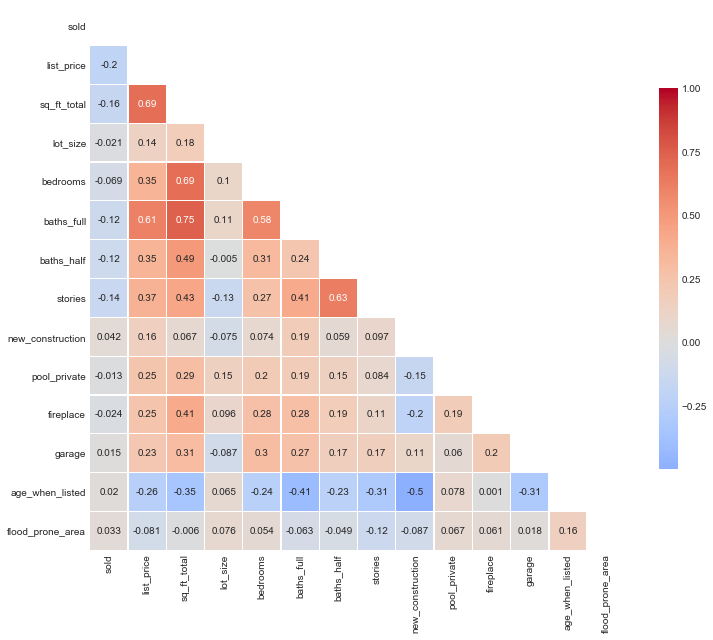

In [28]:
import seaborn as sns
f, ax = plt.subplots(figsize=(12, 10))

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(df.corr(),3), mask=mask, cbar_kws={'shrink':.7}, annot=True, center=0, linewidth=0.3, cmap='coolwarm');

In [29]:
# Drop unnecessary columns

df = df.drop(columns=['sq_ft_total'])

### Standard Scaler

The continuous features need to be scaled to the same scale to analyze them without distorted weighting, as the scales for each may differ. Standard Scaler transforms the data in each feature to have a mean of 0 and a standard deviation of 1.

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [31]:
df_scale = df.copy(deep=True)

In [32]:
numeric_cols = df_scale.describe().columns

In [33]:
df_scale[numeric_cols] = sc.fit_transform(df_scale[numeric_cols])

In [34]:
df_scale.describe().T

,count,mean,std,min,25%,50%,75%,max
list_price,268702.0,-3.215532e-17,1.000002,-1.742302,-0.677618,-0.258197,0.419329,4.581276
lot_size,268702.0,-2.115482e-17,1.000002,-0.912128,-0.359931,-0.213507,-0.010206,8.284438
bedrooms,268702.0,5.214663e-17,1.000002,-3.267284,-0.671076,0.627027,0.627027,1.925131
baths_full,268702.0,2.991291e-16,1.000002,-2.014208,-0.501283,-0.501283,1.011642,2.524567
baths_half,268702.0,0.000000e+00,1.000002,-1.035459,-1.035459,0.846571,0.846571,2.728601
stories,268702.0,8.123450e-17,1.000002,-0.985893,-0.985893,0.745402,0.745402,3.342344
new_construction,268702.0,8.969643e-17,1.000002,-0.449317,-0.449317,-0.449317,-0.449317,2.225600
pool_private,268702.0,-4.696370e-17,1.000002,-0.343834,-0.343834,-0.343834,-0.343834,2.908380
fireplace,268702.0,1.282511e-16,1.000002,-1.283811,-1.283811,0.778931,0.778931,0.778931
garage,268702.0,-1.843642e-16,1.000002,-3.404192,0.293755,0.293755,0.293755,0.293755


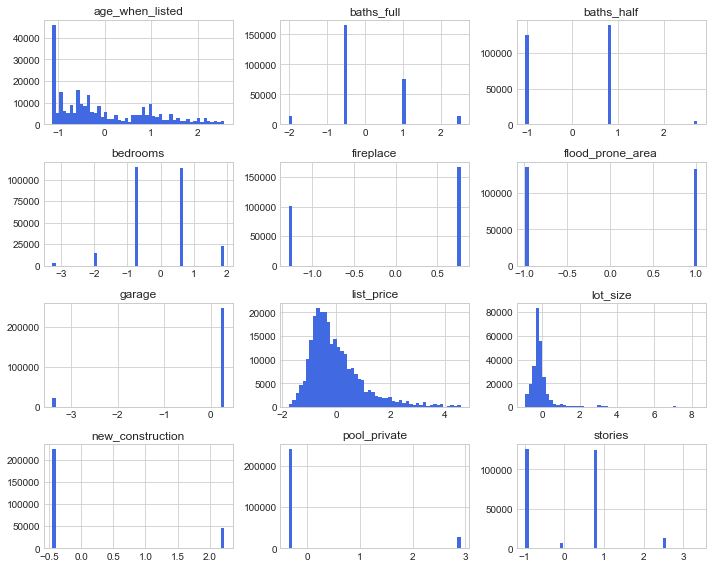

In [35]:
df_scale[numeric_cols][df_scale[numeric_cols].describe().columns].hist(bins=50,figsize=(10,8), color='royalblue')
plt.tight_layout()
plt.show()

### Log Transform

Regression tasks only work with data that is close to normal, for accurate predictive value. Each of the continuous datasets display positive skew. I will perform a log transformation to help the data conform to normality.

In [36]:
df_log = df_scale.copy(deep=True)

In [37]:
for c in [numeric_cols]:
    df_log[c] = np.log(df_log[c]+3.75)

In [38]:
df_log.isna().any()

sold                False
zip_code            False
list_price          False
lot_size            False
bedrooms            False
baths_full          False
baths_half          False
stories             False
new_construction    False
pool_private        False
fireplace           False
garage              False
age_when_listed     False
flood_prone_area    False
dtype: bool

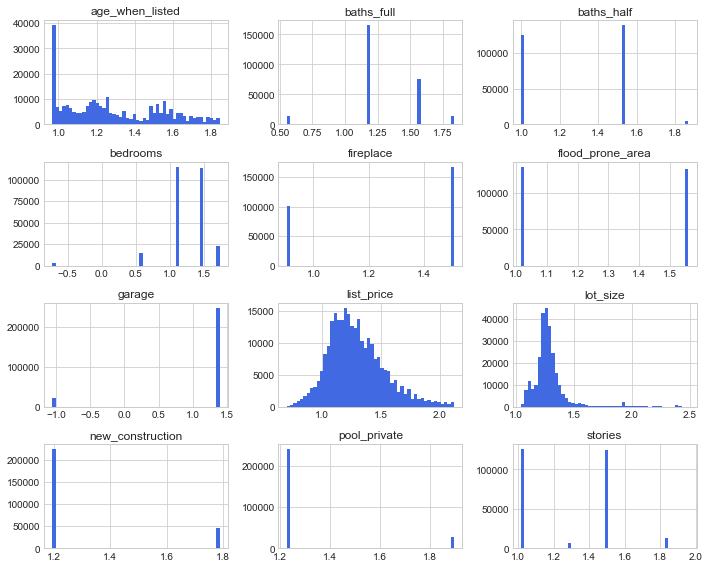

In [39]:
df_log[numeric_cols].hist(bins=50,figsize=(10,8), color='royalblue')
plt.tight_layout()
plt.show()

In [40]:
for each in list(numeric_cols):
    print('For '+str(each)+' the skew is '+str(round(skew(df_log[each]),3))+' and the kurtosis is '+str(round(kurtosis(df_log[each]),3)))

For list_price the skew is 0.708 and the kurtosis is 0.571
For lot_size the skew is 3.298 and the kurtosis is 13.637
For bedrooms the skew is -2.44 and the kurtosis is 11.548
For baths_full the skew is -0.384 and the kurtosis is 1.127
For baths_half the skew is -0.02 and the kurtosis is -1.744
For stories the skew is 0.165 and the kurtosis is -1.434
For new_construction the skew is 1.776 and the kurtosis is 1.155
For pool_private the skew is 2.565 and the kurtosis is 4.577
For fireplace the skew is -0.505 and the kurtosis is -1.745
For garage the skew is -3.11 and the kurtosis is 7.675
For age_when_listed the skew is 0.406 and the kurtosis is -1.052
For flood_prone_area the skew is 0.023 and the kurtosis is -1.999


In [41]:
df_use = df_log.copy(deep=True)

### Binning Zip Codes

In [42]:
df_use['county'] = pd.Series()

In [43]:
Austin_County = ['77418', '77426', '77474', '77485', '77833', '78931', '78933', '78940', '78944', '78950', '78954']
Brazoria_County_N = ['77047', '77430', '77511', '77531', '77546', '77578', '77581', '77583', '77584']
Brazoria_County_S = ['77422', '77444', '77480', '77486', '77515', '77534', '77541', '77566', '77577']
Chambers_County = ['77514', '77520', '77521', '77523', '77560', '77597', '77622', '77665']
Fort_Bend_County_N = ['77082', '77083', '77099', '77406', '77407', '77417', '77435', '77441', '77450', '77471', '77498']
Fort_Bend_County_S = ['77053', '77085', '77420', '77459', '77461', '77469', '77478', '77479', '77489', '77545']
Galveston_County = ['77510', '77517', '77518', '77539', '77550', '77551', '77554', '77563', '77565', '77568', '77573', '77590', '77591']
Harris_Inner_North = ['77003', '77004', '77005', '77006', '77007', '77008', '77009', '77019', '77027', '77046', '77098', '77401']
Harris_Inner_South = ['77002', '77010', '77011', '77012', '77020', '77021', '77023', '77025', '77026', '77030', '77054', '77201']
Harris_NE = ['77013', '77015', '77016', '77022', '77028', '77037', '77039', '77049', '77050', '77060', '77073', '77076', '77078', '77093']
Harris_North = ['77018', '77038', '77088', '77091', '77338', '77345', '77346', '77396', '77336', '77532', '77044', '77530', '77562', '77032', '77315']
Harris_North_Suburbs = ['77041', '77065', '77373', '77375', '77377', '77379', '77388', '77389', '77429', '77433', '77068', '77069', '77449']
Harris_NW = ['77014', '77040', '77043', '77055', '77064', '77066', '77067', '77070', '77080', '77084', '77086', '77090', '77092', '77095']
Harris_SE_Suburbs = ['77536', '77547', '77502', '77503', '77504', '77505', '77506', '77507', '77571', '77586', '77587', '77598', '77058', '77059']
Harris_South = ['77017', '77029', '77033', '77034', '77035', '77045', '77048', '77051', '77061', '77062', '77071', '77075', '77087', '77089']
Harris_SW = ['77024', '77031', '77036', '77042', '77056', '77057', '77063', '77072', '77074', '77077', '77079', '77081', '77094', '77096']
Libery_County = ['77327', '77328', '77357', '77371', '77372', '77535', '77538', '77564', '77575']
Montgomery_County_E = ['77301', '77302', '77303', '77306', '77318', '77339', '77358', '77365', '77378', '77385', '77386']
Montgomery_County_W = ['77304', '77316', '77354', '77356', '77362', '77380', '77381', '77382', '77384', '77447', '77873']
Waller_County = ['77355', '77363', '77423', '77445', '77447', '77484', '77493', '77494']

In [44]:
zipcodes = df_use.zip_code

# df_use.drop(columns='zip_code', inplace=True)df_use.loc[df_use.zip_code.isin(Austin_County), 'county'] = 'Austin_County'
df_use.loc[df_use.zip_code.isin(Brazoria_County_N), 'county'] = 'Brazoria_County_N'
df_use.loc[df_use.zip_code.isin(Brazoria_County_S), 'county'] = 'Brazoria_County_S'
df_use.loc[df_use.zip_code.isin(Chambers_County), 'county'] = 'Chambers_County'
df_use.loc[df_use.zip_code.isin(Fort_Bend_County_N), 'county'] = 'Fort_Bend_County_N'
df_use.loc[df_use.zip_code.isin(Fort_Bend_County_S), 'county'] = 'Fort_Bend_County_S'
df_use.loc[df_use.zip_code.isin(Galveston_County), 'county'] = 'Galveston_County'
df_use.loc[df_use.zip_code.isin(Harris_Inner_North), 'county'] = 'Harris_Inner_North'
df_use.loc[df_use.zip_code.isin(Harris_Inner_South), 'county'] = 'Harris_Inner_South'
df_use.loc[df_use.zip_code.isin(Harris_NE), 'county'] = 'Harris_NE'
df_use.loc[df_use.zip_code.isin(Harris_North), 'county'] = 'Harris_North'
df_use.loc[df_use.zip_code.isin(Harris_North_Suburbs), 'county'] = 'Harris_North_Suburbs'
df_use.loc[df_use.zip_code.isin(Harris_NW), 'county'] = 'Harris_NW'
df_use.loc[df_use.zip_code.isin(Harris_SE_Suburbs), 'county'] = 'Harris_SE_Suburbs'
df_use.loc[df_use.zip_code.isin(Harris_South), 'county'] = 'Harris_South'
df_use.loc[df_use.zip_code.isin(Harris_SW), 'county'] = 'Harris_SW'
df_use.loc[df_use.zip_code.isin(Libery_County), 'county'] = 'Libery_County'
df_use.loc[df_use.zip_code.isin(Montgomery_County_E), 'county'] = 'Montgomery_County_E'
df_use.loc[df_use.zip_code.isin(Montgomery_County_W), 'county'] = 'Montgomery_County_W'
df_use.loc[df_use.zip_code.isin(Waller_County), 'county'] = 'Waller_County'

In [45]:
zipcodes = df_use.zip_code

In [46]:
df_use.drop(columns='zip_code', inplace=True)

### One Hot Encoding

Categorical data must be transformed to numeric data for modeling. To do that, I will use one hot encoding, which breaks the options for each feature into individual columns, detailing whether or not the entry for that line contains each feature option.

In [47]:
view(df_use,3)

,sold,list_price,lot_size,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,fireplace,garage,age_when_listed,flood_prone_area,county
0,True,0.758984,1.126635,0.577074,0.551464,0.998623,1.016718,1.194129,1.225587,0.902674,-1.061871,1.808910,1.560572,Chambers_County
1,True,0.712931,1.113265,-0.728326,0.551464,0.998623,1.503055,1.194129,1.225587,1.510486,1.397174,1.480431,1.015742,Galveston_County
2,True,0.747133,1.104557,-0.728326,0.551464,0.998623,1.016718,1.194129,1.225587,0.902674,-1.061871,1.539415,1.015742,Montgomery_County_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301002,False,2.118466,1.136194,1.476370,1.560593,1.525311,1.828846,1.194129,1.225587,1.510486,1.397174,0.967928,1.015742,Harris_Inner_North
301003,False,2.119242,1.303330,1.476370,1.560593,1.525311,1.503055,1.194129,1.225587,1.510486,1.397174,1.201995,1.560572,Harris_Inner_South
301004,False,2.119939,1.614340,0.577074,1.178260,0.998623,1.016718,1.194129,1.225587,0.902674,1.397174,1.834820,1.560572,Harris_NW


In [48]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268702 entries, 0 to 301004
Data columns (total 14 columns):
sold                268702 non-null bool
list_price          268702 non-null float64
lot_size            268702 non-null float64
bedrooms            268702 non-null float64
baths_full          268702 non-null float64
baths_half          268702 non-null float64
stories             268702 non-null float64
new_construction    268702 non-null float64
pool_private        268702 non-null float64
fireplace           268702 non-null float64
garage              268702 non-null float64
age_when_listed     268702 non-null float64
flood_prone_area    268702 non-null float64
county              267827 non-null object
dtypes: bool(1), float64(12), object(1)
memory usage: 29.0+ MB


In [49]:
# Fix data types

df_use.new_construction = df_use.new_construction.astype('int')
df_use.pool_private = df_use.pool_private.astype('int')
df_use.fireplace = df_use.fireplace.astype('int')
df_use.garage = df_use.garage.astype('int')

In [50]:
# Separate target and features

X = df_use.drop(columns=['sold']) # Features
y = df_use['sold'] # Target

In [51]:
# Get dummies

X = pd.get_dummies(X, drop_first=True)

In [52]:
# Preview one hot encoded features

view(X,2)

,list_price,lot_size,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,fireplace,garage,age_when_listed,flood_prone_area,county_Brazoria_County_S,county_Chambers_County,county_Fort_Bend_County_N,county_Fort_Bend_County_S,county_Galveston_County,county_Harris_Inner_North,county_Harris_Inner_South,county_Harris_NE,county_Harris_NW,county_Harris_North,county_Harris_North_Suburbs,county_Harris_SE_Suburbs,county_Harris_SW,county_Harris_South,county_Libery_County,county_Montgomery_County_E,county_Montgomery_County_W,county_Waller_County
0,0.758984,1.126635,0.577074,0.551464,0.998623,1.016718,1,1,0,-1,1.808910,1.560572,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.712931,1.113265,-0.728326,0.551464,0.998623,1.503055,1,1,1,1,1.480431,1.015742,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301003,2.119242,1.303330,1.476370,1.560593,1.525311,1.503055,1,1,1,1,1.201995,1.560572,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
301004,2.119939,1.614340,0.577074,1.178260,0.998623,1.016718,1,1,0,1,1.834820,1.560572,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


#### _Export in case kernel needs to restart_

In [53]:
# Saving the cleaned features set
# X.to_csv('features.csv')

# Saving the cleaned target variable
# y.to_csv('target.txt')

## Modeling

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, classification_report

import itertools

In [55]:
# Separating the data into a training and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"Training set has {X_train.shape[0]} samples")
print(f"Testing set has {X_test.shape[0]} samples")

Training set has 214961 samples
Testing set has 53741 samples


#### _Export training/test sets in case kernel needs to restart_

In [56]:
# X_train.to_csv('default_X_train.csv')
# X_test.to_csv('default_X_test.csv')
# y_train.to_csv('default_y_train.txt')
# y_test.to_csv('default_y_test.txt')

In [57]:
# Defining a function to plot a confusion matrix

def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

### XGBoost

In [58]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [59]:
import xgboost as xgb

In [60]:
# instantiate
booster = xgb.XGBClassifier()

# train the xgboost
booster.fit(X_train, y_train)

# predict
train_preds_booster = booster.predict(X_train)
test_preds_booster = booster.predict(X_test)

# evaluate
train_accuracy_booster = accuracy_score(y_train, train_preds_booster)
test_accuracy_booster = accuracy_score(y_test, test_preds_booster)
report_booster = classification_report(y_test, test_preds_booster)

print("XGBoost")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster * 100):.4}%")

print("\nClassification report:")
print(report_booster)
print()

XGBoost
-------------------------
Training Accuracy: 67.63%
Test Accuracy:     67.7%

Classification report:
              precision    recall  f1-score   support

       False       0.57      0.25      0.35     18485
        True       0.70      0.90      0.79     35256

    accuracy                           0.68     53741
   macro avg       0.63      0.58      0.57     53741
weighted avg       0.65      0.68      0.63     53741




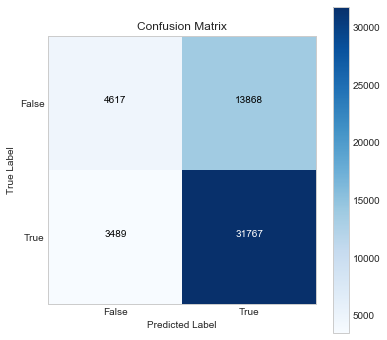

In [61]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_booster);

AUC: 0.5754


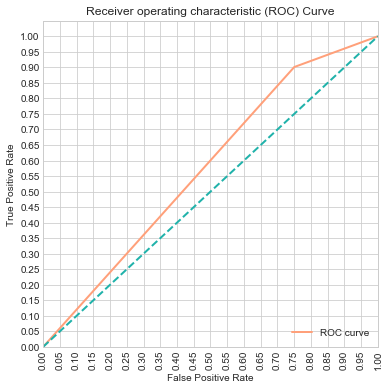

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_booster)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [63]:
booster_feat_weights = pd.DataFrame(booster.feature_importances_, 
                                    columns=['weight'], 
                                    index=X.columns).sort_values('weight', ascending=False)

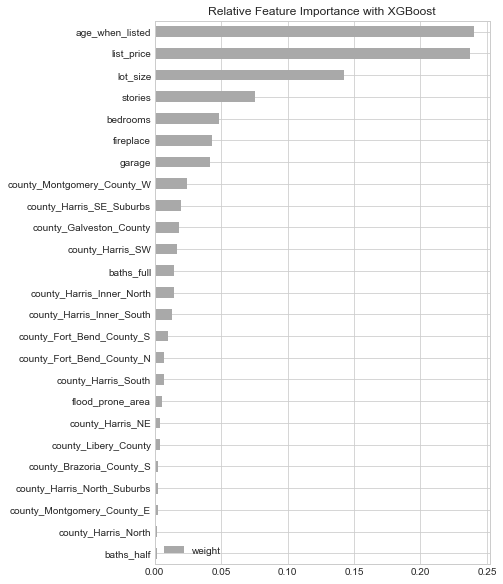

In [64]:
booster_feat_weights[booster_feat_weights.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,10))
plt.title('Relative Feature Importance with XGBoost');

In [65]:
print('Ranking Features from XGBoost:')
booster_feat_weights.sort_values('weight',ascending=False)

Ranking Features from XGBoost:


,weight
age_when_listed,0.240000
list_price,0.237143
lot_size,0.142857
stories,0.075714
bedrooms,0.048571
fireplace,0.042857
garage,0.041429
county_Montgomery_County_W,0.024286
county_Harris_SE_Suburbs,0.020000
county_Galveston_County,0.018571


In [66]:
print('Least Important Features from XGBoost:')
print(f'({len(booster_feat_weights[booster_feat_weights.weight==0])} features with weight of 0.0)')
booster_feat_weights[booster_feat_weights.weight==0]

Least Important Features from XGBoost:
(5 features with weight of 0.0)


,weight
county_Chambers_County,0.0
county_Harris_NW,0.0
pool_private,0.0
new_construction,0.0
county_Waller_County,0.0


## Balancing the Data

To balance the data, I will use SMOTE: Synthetic Minority Over-sampling Technique. This is an oversampling technique that helps address class imbalance by generating synthetic data based on the feature space similarities between existing instances in the minority class.

In [67]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [68]:
# Previous class distribution

print(y.value_counts())

True     176024
False     92678
Name: sold, dtype: int64


In [69]:
# Resample the training data
X_resamp, y_resamp = SMOTE().fit_sample(X_train, y_train) 

# View synthetic sample class distribution
print(pd.Series(y_resamp).value_counts())
print()

True     140768
False    140768
Name: sold, dtype: int64



In [70]:
# Separating the resampled data into a training and testing set

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resamp, y_resamp, test_size=0.2, random_state=0)

### XGBoost

In [71]:
# instantiate
booster2 = xgb.XGBClassifier()

# train the xgboost
booster2.fit(X_train2, y_train2)

# predict
train_preds_booster2 = booster2.predict(X_train2)
test_preds_booster2 = booster2.predict(X_test2)

# evaluate
train_accuracy_booster2 = accuracy_score(y_train2, train_preds_booster2)
test_accuracy_booster2 = accuracy_score(y_test2, test_preds_booster2)
report_booster2 = classification_report(y_test2, test_preds_booster2)

print("XGBoost - After Balancing")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster2 * 100):.4}%")

print("\nClassification report:")
print(report_booster2)
print()

XGBoost - After Balancing
-------------------------
Training Accuracy: 65.54%
Test Accuracy:     65.55%

Classification report:
              precision    recall  f1-score   support

       False       0.65      0.66      0.66     28194
        True       0.66      0.65      0.65     28114

    accuracy                           0.66     56308
   macro avg       0.66      0.66      0.66     56308
weighted avg       0.66      0.66      0.66     56308




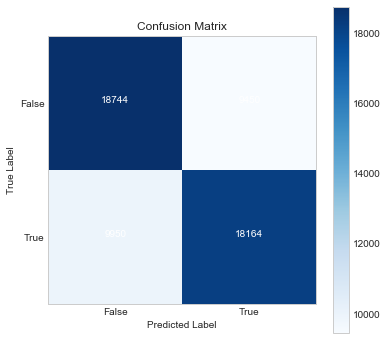

In [72]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test2, test_preds_booster2);

AUC: 0.65545


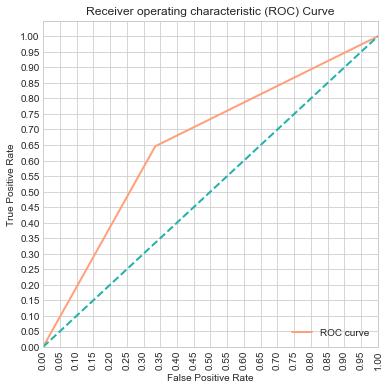

In [73]:
fpr, tpr, thresholds = roc_curve(y_test2, test_preds_booster2)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
booster_feat_weights2 = pd.DataFrame(booster2.feature_importances_, 
                                    columns=['weight'], 
                                    index=X.columns).sort_values('weight', ascending=False)

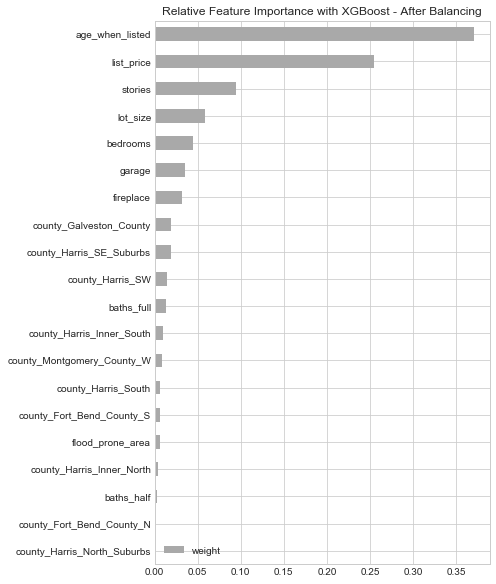

In [75]:
booster_feat_weights2[booster_feat_weights2.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,10))
plt.title('Relative Feature Importance with XGBoost - After Balancing');

In [76]:
print('Ranking Features from XGBoost - After Balancing:')
booster_feat_weights2.sort_values('weight',ascending=False)

Ranking Features from XGBoost - After Balancing:


,weight
age_when_listed,0.370478
list_price,0.254703
stories,0.094067
lot_size,0.057887
bedrooms,0.044863
garage,0.034732
fireplace,0.031838
county_Harris_SE_Suburbs,0.018813
county_Galveston_County,0.018813
county_Harris_SW,0.014472


In [77]:
print('Least Important Features from XGBoost - After Balancing:')
print(f'({len(booster_feat_weights2[booster_feat_weights2.weight==0])} features with weight of 0.0)')
booster_feat_weights2[booster_feat_weights2.weight==0]

Least Important Features from XGBoost - After Balancing:
(10 features with weight of 0.0)


,weight
county_Chambers_County,0.0
county_Brazoria_County_S,0.0
county_Harris_NE,0.0
county_Harris_NW,0.0
county_Harris_North,0.0
pool_private,0.0
new_construction,0.0
county_Libery_County,0.0
county_Montgomery_County_E,0.0
county_Waller_County,0.0


In [78]:
score_xgb = ['XGBoost', train_accuracy_booster2, test_accuracy_booster2]

### XGBoost after Removing Low-Ranking Features

In [79]:
booster_feat_weights2[booster_feat_weights2.weight>0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, age_when_listed to county_Harris_North_Suburbs
Data columns (total 1 columns):
weight    20 non-null float32
dtypes: float32(1)
memory usage: 240.0+ bytes


In [80]:
X3 = X[booster_feat_weights2[booster_feat_weights.weight>0].index] # Features
y3 = df_use['sold'] # Target

In [81]:
# Preview one hot encoded features

view(X3,2)

,age_when_listed,list_price,stories,lot_size,bedrooms,garage,fireplace,county_Harris_SE_Suburbs,county_Galveston_County,county_Harris_SW,baths_full,county_Harris_Inner_South,county_Montgomery_County_W,county_Harris_South,county_Fort_Bend_County_S,flood_prone_area,county_Harris_Inner_North,baths_half,county_Fort_Bend_County_N,county_Harris_North_Suburbs,county_Brazoria_County_S,county_Harris_NE,county_Harris_North,county_Libery_County,county_Montgomery_County_E
0,1.808910,0.758984,1.016718,1.126635,0.577074,-1,0,0,0,0,0.551464,0,0,0,0,1.560572,0,0.998623,0,0,0,0,0,0,0
1,1.480431,0.712931,1.503055,1.113265,-0.728326,1,1,0,1,0,0.551464,0,0,0,0,1.015742,0,0.998623,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301003,1.201995,2.119242,1.503055,1.303330,1.476370,1,1,0,0,0,1.560593,1,0,0,0,1.560572,0,1.525311,0,0,0,0,0,0,0
301004,1.834820,2.119939,1.016718,1.614340,0.577074,1,0,0,0,0,1.178260,0,0,0,0,1.560572,0,0.998623,0,0,0,0,0,0,0


In [82]:
# Separating the data into a training and testing set

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=2)

print(f"Training set has {X_train3.shape[0]} samples")
print(f"Testing set has {X_test3.shape[0]} samples")

Training set has 214961 samples
Testing set has 53741 samples


In [83]:
# instantiate
booster3 = xgb.XGBClassifier()

# train the xgboost
booster3.fit(X_train3, y_train3)

# predict
train_preds_booster3 = booster3.predict(X_train3)
test_preds_booster3 = booster3.predict(X_test3)

# evaluate
train_accuracy_booster3 = accuracy_score(y_train3, train_preds_booster3)
test_accuracy_booster3 = accuracy_score(y_test3, test_preds_booster3)
report_booster3 = classification_report(y_test3, test_preds_booster3)

print("XGBoost 3 - balanced and 0-weight features removed")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster3 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster3 * 100):.4}%")

print("\nClassification report:")
print(report_booster3)
print()

XGBoost 3 - balanced and 0-weight features removed
-------------------------
Training Accuracy: 67.63%
Test Accuracy:     67.56%

Classification report:
              precision    recall  f1-score   support

       False       0.56      0.25      0.34     18471
        True       0.70      0.90      0.78     35270

    accuracy                           0.68     53741
   macro avg       0.63      0.57      0.56     53741
weighted avg       0.65      0.68      0.63     53741




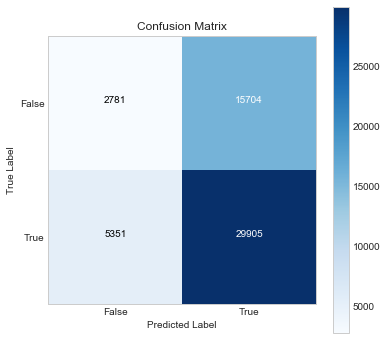

In [84]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_booster3);

AUC: 0.57379


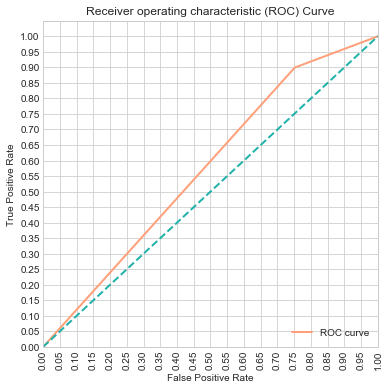

In [85]:
fpr, tpr, thresholds = roc_curve(y_test3, test_preds_booster3)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [86]:
booster_feat_weights3 = pd.DataFrame(booster3.feature_importances_, 
                                    columns=['weight'], 
                                    index=X3.columns).sort_values('weight', ascending=False)

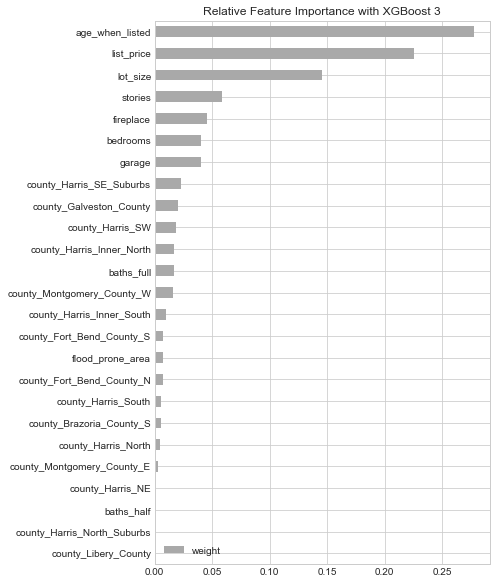

In [87]:
booster_feat_weights3[booster_feat_weights3.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,10))
plt.title('Relative Feature Importance with XGBoost 3');

In [88]:
print('Most Important Features from XGBoost 3:')
booster_feat_weights3.sort_values('weight',ascending=False)

Most Important Features from XGBoost 3:


,weight
age_when_listed,0.277143
list_price,0.225714
lot_size,0.145714
stories,0.058571
fireplace,0.045714
bedrooms,0.040000
garage,0.040000
county_Harris_SE_Suburbs,0.022857
county_Galveston_County,0.020000
county_Harris_SW,0.018571


In [89]:
score_xgb2 = ['XGBoost Low Ranked Features Removed', train_accuracy_booster3, test_accuracy_booster3]

### XGBoost after Removing Counties

In [90]:
non_county_feats = booster_feat_weights2.index[~booster_feat_weights2.index.str.contains('county')]

In [91]:
X4 = X[non_county_feats] # Features
y4 = df_use['sold'] # Target

In [92]:
# Preview one hot encoded features

view(X4,2)

,age_when_listed,list_price,stories,lot_size,bedrooms,garage,fireplace,baths_full,flood_prone_area,baths_half,pool_private,new_construction
0,1.808910,0.758984,1.016718,1.126635,0.577074,-1,0,0.551464,1.560572,0.998623,1,1
1,1.480431,0.712931,1.503055,1.113265,-0.728326,1,1,0.551464,1.015742,0.998623,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
301003,1.201995,2.119242,1.503055,1.303330,1.476370,1,1,1.560593,1.560572,1.525311,1,1
301004,1.834820,2.119939,1.016718,1.614340,0.577074,1,0,1.178260,1.560572,0.998623,1,1


In [93]:
# Separating the data into a training and testing set

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.2, random_state=2)

print(f"Training set has {X_train4.shape[0]} samples")
print(f"Testing set has {X_test4.shape[0]} samples")

Training set has 214961 samples
Testing set has 53741 samples


In [94]:
# instantiate
booster4 = xgb.XGBClassifier()

# train the xgboost
booster4.fit(X_train4, y_train4)

# predict
train_preds_booster4 = booster4.predict(X_train4)
test_preds_booster4 = booster4.predict(X_test4)

# evaluate
train_accuracy_booster4 = accuracy_score(y_train4, train_preds_booster4)
test_accuracy_booster4 = accuracy_score(y_test4, test_preds_booster4)
report_booster4 = classification_report(y_test4, test_preds_booster4)

print("XGBoost 4 - balanced without location")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster4 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster4 * 100):.4}%")

print("\nClassification report:")
print(report_booster4)
print()

XGBoost 4 - balanced without location
-------------------------
Training Accuracy: 67.44%
Test Accuracy:     67.38%

Classification report:
              precision    recall  f1-score   support

       False       0.56      0.25      0.35     18471
        True       0.70      0.90      0.78     35270

    accuracy                           0.67     53741
   macro avg       0.63      0.57      0.56     53741
weighted avg       0.65      0.67      0.63     53741




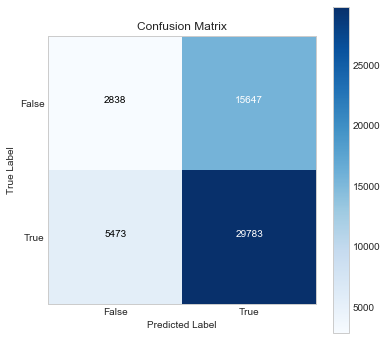

In [95]:
# Confusion matrix

plt.figure(figsize=(6,6))
plot_cf(y_test, test_preds_booster4);

AUC: 0.57302


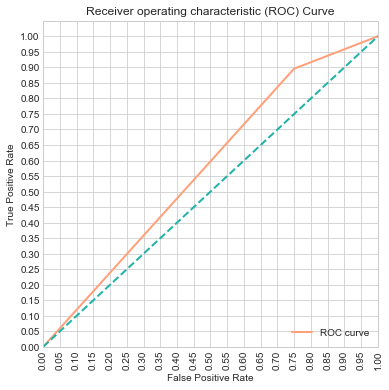

In [96]:
fpr, tpr, thresholds = roc_curve(y_test4, test_preds_booster4)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [97]:
booster_feat_weights4 = pd.DataFrame(booster4.feature_importances_, 
                                    columns=['weight'], 
                                    index=X4.columns).sort_values('weight', ascending=False)

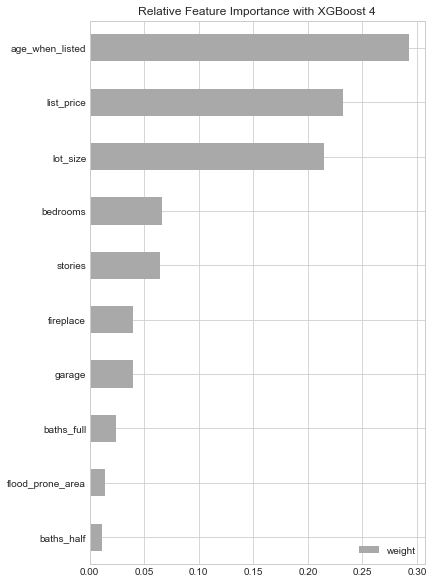

In [98]:
booster_feat_weights4[booster_feat_weights4.weight>0].sort_values('weight', ascending=True).plot(kind='barh', color='darkgrey', figsize=(6,10))
plt.title('Relative Feature Importance with XGBoost 4');

In [99]:
print('Most Important Features from XGBoost 4:')
booster_feat_weights4.sort_values('weight',ascending=False)

Most Important Features from XGBoost 4:


,weight
age_when_listed,0.292264
list_price,0.232092
lot_size,0.214900
bedrooms,0.065903
stories,0.064470
garage,0.040115
fireplace,0.040115
baths_full,0.024355
flood_prone_area,0.014327
baths_half,0.011461


In [100]:
score_xgb3 = ['XGBoost Location Removed', train_accuracy_booster4, test_accuracy_booster4]

### Neural Network Model 1: Baseline

In [101]:
from keras import models, layers, optimizers, regularizers
from keras.callbacks import EarlyStopping

In [102]:
model = models.Sequential()

model.add(layers.Dense(12, 
                       kernel_initializer='uniform', 
                       activation='relu', 
                       input_shape=(X_train2.shape[1],)))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 499
Trainable params: 499
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [105]:
history = model.fit(X_train2,
                    y_train2,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)

Train on 180182 samples, validate on 45046 samples
Epoch 1/10
180182/180182 [==============================] - 1s 8us/step - loss: 0.6804 - acc: 0.5745 - val_loss: 0.6735 - val_acc: 0.5892
Epoch 2/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6680 - acc: 0.5993 - val_loss: 0.6686 - val_acc: 0.5933
Epoch 3/10
180182/180182 [==============================] - 1s 5us/step - loss: 0.6625 - acc: 0.6072 - val_loss: 0.6612 - val_acc: 0.6072
Epoch 4/10
180182/180182 [==============================] - 1s 5us/step - loss: 0.6589 - acc: 0.6112 - val_loss: 0.6595 - val_acc: 0.6060
Epoch 5/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6577 - acc: 0.6121 - val_loss: 0.6596 - val_acc: 0.6046
Epoch 6/10
180182/180182 [==============================] - 1s 5us/step - loss: 0.6571 - acc: 0.6133 - val_loss: 0.6601 - val_acc: 0.6026
Epoch 7/10
180182/180182 [==============================] - 1s 5us/step - loss: 0.6563 - acc: 0.6139 - val_loss: 0.6589 -

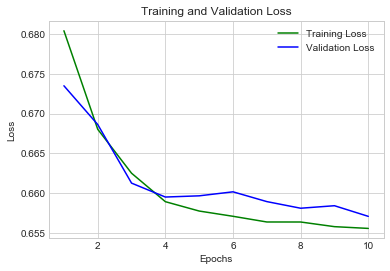

In [106]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'green', label='Training Loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

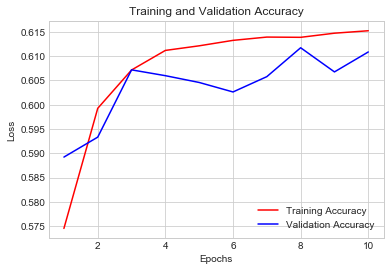

In [107]:
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'red', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
base_train_loss, base_train_acc = model.evaluate(X_train2, y_train2)
print(f'Base Train Loss:      {(base_train_loss * 100):.4}%')
print(f'Base Train Accuracy:  {(base_train_acc * 100):.4}%')

225228/225228 [==============================] - 6s 26us/step
Base Train Loss:      65.5%
Base Train Accuracy:  61.56%


In [109]:
base_test_loss, base_test_acc = model.evaluate(X_test2, y_test2)
print(f'Base Test Loss:      {(base_test_loss * 100):.4}%')
print(f'Base Test Accuracy:  {(base_test_acc * 100):.4}%')

56308/56308 [==============================] - 1s 25us/step
Base Test Loss:      65.63%
Base Test Accuracy:  61.23%


In [110]:
base_hat_test = model.predict(X_test2)

AUC: 0.65338


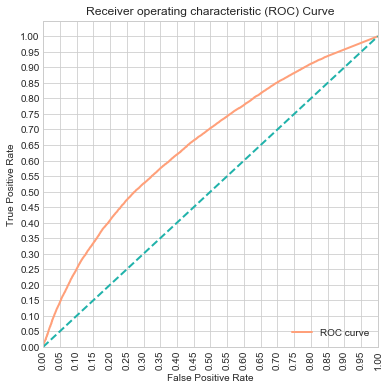

In [111]:
fpr, tpr, thresholds = roc_curve(y_test2, base_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [112]:
score_NN1 = ['Baseline NN', base_train_acc, base_test_acc]

### Neural Network Model 2: L1 Regularization

In [113]:
model2 = models.Sequential()

model2.add(layers.Dense(12, 
                       kernel_regularizer=regularizers.l1(0.005), 
                       activation='relu', 
                       input_shape=(X_train2.shape[1],)))
model2.add(layers.Dense(6, 
                        kernel_regularizer=regularizers.l1(0.005),
                        activation='relu'))
model2.add(layers.Dense(6, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [114]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
Total params: 499
Trainable params: 499
Non-trainable params: 0
_________________________________________________________________


In [115]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [116]:
history2 = model2.fit(X_train2,
                    y_train2,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)

Train on 180182 samples, validate on 45046 samples
Epoch 1/10
180182/180182 [==============================] - 2s 9us/step - loss: 0.8863 - acc: 0.5640 - val_loss: 0.7206 - val_acc: 0.6028
Epoch 2/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6937 - acc: 0.6042 - val_loss: 0.6819 - val_acc: 0.6071
Epoch 3/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6775 - acc: 0.6080 - val_loss: 0.6751 - val_acc: 0.6060
Epoch 4/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6732 - acc: 0.6080 - val_loss: 0.6728 - val_acc: 0.6054
Epoch 5/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6713 - acc: 0.6087 - val_loss: 0.6717 - val_acc: 0.6033
Epoch 6/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6703 - acc: 0.6084 - val_loss: 0.6717 - val_acc: 0.6021
Epoch 7/10
180182/180182 [==============================] - 1s 6us/step - loss: 0.6696 - acc: 0.6088 - val_loss: 0.6708 -

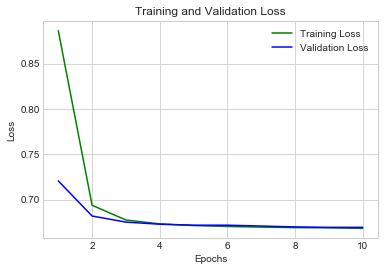

In [117]:
history_dict2 = history2.history
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(loss_values2) + 1)
plt.plot(epochs2, loss_values2, 'green', label='Training Loss')
plt.plot(epochs2, val_loss_values2, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

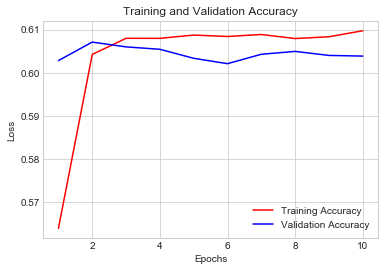

In [118]:
acc_values2 = history_dict2['acc'] 
val_acc_values2 = history_dict2['val_acc']

plt.plot(epochs2, acc_values2, 'red', label='Training Accuracy')
plt.plot(epochs2, val_acc_values2, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [119]:
model2_train_loss, model2_train_acc = model2.evaluate(X_train2, y_train2)
print(f'Model 2 Train Loss:      {(model2_train_loss * 100):.4}%')
print(f'Model 2 Train Accuracy:  {(model2_train_acc * 100):.4}%')

225228/225228 [==============================] - 6s 27us/step
Model 2 Train Loss:      66.81%
Model 2 Train Accuracy:  60.66%


In [120]:
model2_test_loss, model2_test_acc = model2.evaluate(X_test2, y_test2)
print(f'Model 2 Test Loss:      {(model2_test_loss * 100):.4}%')
print(f'Model 2 Test Accuracy:  {(model2_test_acc * 100):.4}%')

56308/56308 [==============================] - 2s 28us/step
Model 2 Test Loss:      66.88%
Model 2 Test Accuracy:  60.43%


In [121]:
model2_hat_test = model2.predict(X_test2)

AUC: 0.64635


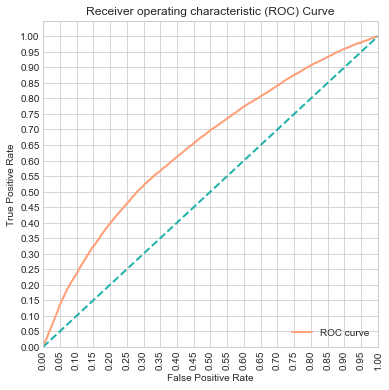

In [122]:
fpr, tpr, thresholds = roc_curve(y_test2, model2_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [123]:
score_NN2 = ['NN: L1 Regularization', model2_train_acc, model2_test_acc]

### Neural Network Model 3: L2 Regularization

In [124]:
model3 = models.Sequential()
model3.add(layers.Dense(12, 
                       kernel_regularizer=regularizers.l2(0.005), 
                       activation='relu', 
                       input_shape=(X_train.shape[1],)))
model3.add(layers.Dense(6, 
                        kernel_regularizer=regularizers.l2(0.005),
                        activation='relu'))
model3.add(layers.Dense(6, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [125]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 499
Trainable params: 499
Non-trainable params: 0
_________________________________________________________________


In [126]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [127]:
history3 = model3.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)

Train on 171968 samples, validate on 42993 samples
Epoch 1/10
171968/171968 [==============================] - 1s 8us/step - loss: 0.7026 - acc: 0.6490 - val_loss: 0.6604 - val_acc: 0.6555
Epoch 2/10
171968/171968 [==============================] - 1s 7us/step - loss: 0.6485 - acc: 0.6548 - val_loss: 0.6389 - val_acc: 0.6574
Epoch 3/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6341 - acc: 0.6587 - val_loss: 0.6286 - val_acc: 0.6628
Epoch 4/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6278 - acc: 0.6615 - val_loss: 0.6246 - val_acc: 0.6645
Epoch 5/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6249 - acc: 0.6629 - val_loss: 0.6222 - val_acc: 0.6642
Epoch 6/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6230 - acc: 0.6638 - val_loss: 0.6211 - val_acc: 0.6649
Epoch 7/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6217 - acc: 0.6640 - val_loss: 0.6199 -

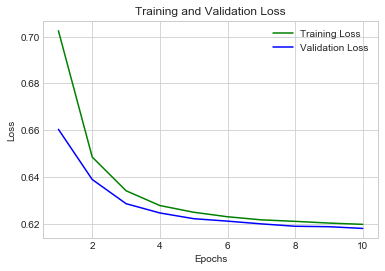

In [128]:
history_dict3 = history3.history
loss_values3 = history_dict3['loss']
val_loss_values3 = history_dict3['val_loss']

epochs3 = range(1, len(loss_values3) + 1)
plt.plot(epochs3, loss_values3, 'green', label='Training Loss')
plt.plot(epochs3, val_loss_values3, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

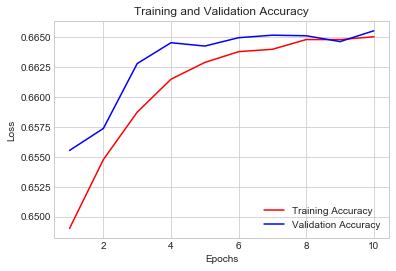

In [129]:
acc_values3 = history_dict3['acc'] 
val_acc_values3 = history_dict3['val_acc']

plt.plot(epochs3, acc_values3, 'red', label='Training Accuracy')
plt.plot(epochs3, val_acc_values3, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [130]:
model3_train_loss, model3_train_acc = model3.evaluate(X_train, y_train)
print(f'Model 3 Train Loss:      {(model3_train_loss * 100):.4}%')
print(f'Model 3 Train Accuracy:  {(model3_train_acc * 100):.4}%')

214961/214961 [==============================] - 6s 30us/step
Model 3 Train Loss:      61.9%
Model 3 Train Accuracy:  66.53%


In [131]:
model3_test_loss, model3_test_acc = model3.evaluate(X_test, y_test)
print(f'Model 3 Test Loss:      {(model3_test_loss * 100):.4}%')
print(f'Model 3 Test Accuracy:  {(model3_test_acc * 100):.4}%')

53741/53741 [==============================] - 1s 25us/step
Model 3 Test Loss:      61.84%
Model 3 Test Accuracy:  66.74%


In [132]:
model3_hat_test = model2.predict(X_test)

AUC: 0.6483


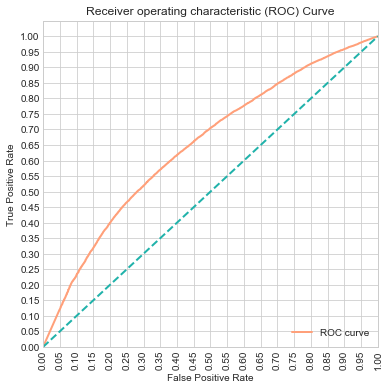

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, model3_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [134]:
score_NN3 = ['NN: L2 Regularization', model3_train_acc, model3_test_acc]

### Neural Network Model 4: Dropout Regularization

In [135]:
model4 = models.Sequential()

model4.add(layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)))
model4.add(layers.Dense(6, activation='relu'))
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(6, activation='relu'))
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(1, activation='sigmoid'))

In [136]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 78        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 7         
Total params: 499
Trainable params: 499
Non-trainable params: 0
_________________________________________________________________


In [137]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [138]:
history4 = model4.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)

Train on 171968 samples, validate on 42993 samples
Epoch 1/10
171968/171968 [==============================] - 2s 10us/step - loss: 0.6470 - acc: 0.6497 - val_loss: 0.6339 - val_acc: 0.6555
Epoch 2/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6341 - acc: 0.6547 - val_loss: 0.6291 - val_acc: 0.6555
Epoch 3/10
171968/171968 [==============================] - 1s 7us/step - loss: 0.6310 - acc: 0.6547 - val_loss: 0.6253 - val_acc: 0.6555
Epoch 4/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6291 - acc: 0.6547 - val_loss: 0.6242 - val_acc: 0.6555
Epoch 5/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6283 - acc: 0.6547 - val_loss: 0.6235 - val_acc: 0.6555
Epoch 6/10
171968/171968 [==============================] - 1s 7us/step - loss: 0.6271 - acc: 0.6547 - val_loss: 0.6231 - val_acc: 0.6555
Epoch 7/10
171968/171968 [==============================] - 1s 7us/step - loss: 0.6263 - acc: 0.6547 - val_loss: 0.6200 

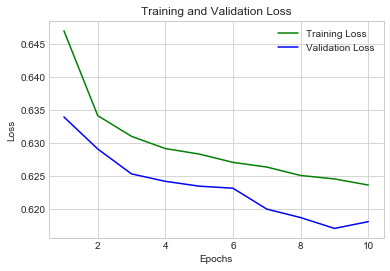

In [139]:
history_dict4 = history4.history
loss_values4 = history_dict4['loss']
val_loss_values4 = history_dict4['val_loss']

epochs4 = range(1, len(loss_values4) + 1)
plt.plot(epochs4, loss_values4, 'g', label='Training Loss')
plt.plot(epochs4, val_loss_values4, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

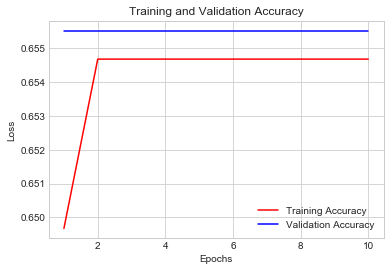

In [140]:
acc_values4 = history_dict4['acc'] 
val_acc_values4 = history_dict4['val_acc']

plt.plot(epochs4, acc_values4, 'r', label='Training Accuracy')
plt.plot(epochs4, val_acc_values4, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [141]:
model4_train_loss, model4_train_acc = model4.evaluate(X_train, y_train)
print(f'Model 4 Train Loss:      {(model4_train_loss * 100):.4}%')
print(f'Model 4 Train Accuracy:  {(model4_train_acc * 100):.4}%')

214961/214961 [==============================] - 7s 31us/step
Model 4 Train Loss:      61.89%
Model 4 Train Accuracy:  65.49%


In [142]:
model4_test_loss, model4_test_acc = model4.evaluate(X_test, y_test)
print(f'Model 4 Test Loss:      {(model4_test_loss * 100):.4}%')
print(f'Model 4 Test Accuracy:  {(model4_test_acc * 100):.4}%')

53741/53741 [==============================] - 2s 32us/step
Model 4 Test Loss:      61.85%
Model 4 Test Accuracy:  65.6%


In [143]:
model4_hat_test = model4.predict(X_test)

AUC: 0.64669


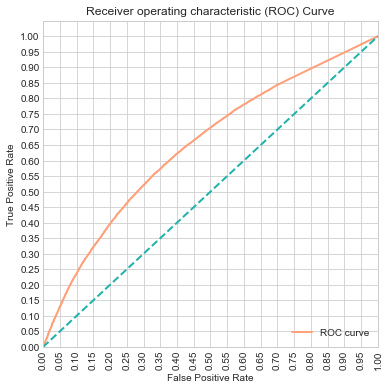

In [144]:
fpr, tpr, thresholds = roc_curve(y_test, model4_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [145]:
score_NN4 = ['NN: Dropout Regularization', model4_train_acc, model4_test_acc]

### Neural Network Model 5: Dropping Features Indicated Insignificant by XGBoost

In [146]:
X2 = X.drop(columns=list(booster_feat_weights[booster_feat_weights.weight==0].index))

In [147]:
# Separating the data into a training and testing set

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=2)

print(f"Training set has {X2_train.shape[0]} samples")
print(f"Testing set has {X2_test.shape[0]} samples")

Training set has 214961 samples
Testing set has 53741 samples


In [148]:
model5 = models.Sequential()

model5.add(layers.Dense(12, 
                       kernel_initializer='uniform', 
                       activation='relu', 
                       input_shape=(X2_train.shape[1],)))
model5.add(layers.Dense(6, activation='relu'))
model5.add(layers.Dense(6, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

**Note:** I first tried my baseline model with 3 layers, and then with 4. The 4-layer neural network had slightly better results, so I decided to go with 4.

In [149]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 12)                312       
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 7         
Total params: 439
Trainable params: 439
Non-trainable params: 0
_________________________________________________________________


In [150]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [151]:
history5 = model5.fit(X2_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)

Train on 171968 samples, validate on 42993 samples
Epoch 1/10
171968/171968 [==============================] - 2s 10us/step - loss: 0.6397 - acc: 0.6537 - val_loss: 0.6253 - val_acc: 0.6594
Epoch 2/10
171968/171968 [==============================] - 1s 7us/step - loss: 0.6225 - acc: 0.6601 - val_loss: 0.6198 - val_acc: 0.6614
Epoch 3/10
171968/171968 [==============================] - 1s 7us/step - loss: 0.6188 - acc: 0.6612 - val_loss: 0.6165 - val_acc: 0.6628
Epoch 4/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6165 - acc: 0.6629 - val_loss: 0.6148 - val_acc: 0.6644
Epoch 5/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6147 - acc: 0.6640 - val_loss: 0.6140 - val_acc: 0.6634
Epoch 6/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.6143 - acc: 0.6647 - val_loss: 0.6132 - val_acc: 0.6647
Epoch 7/10
171968/171968 [==============================] - 1s 5us/step - loss: 0.6139 - acc: 0.6651 - val_loss: 0.6126 

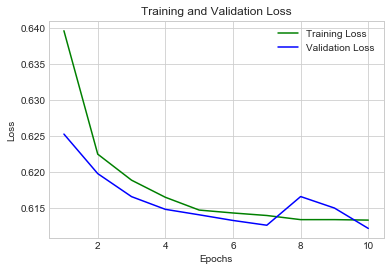

In [152]:
history_dict5 = history5.history
loss_values5 = history_dict5['loss']
val_loss_values5 = history_dict5['val_loss']

epochs5 = range(1, len(loss_values5) + 1)
plt.plot(epochs5, loss_values5, 'green', label='Training Loss')
plt.plot(epochs5, val_loss_values5, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

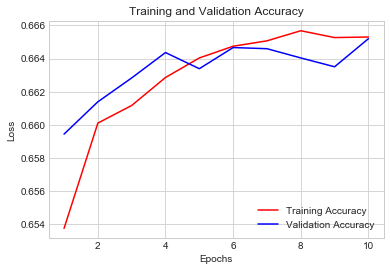

In [153]:
acc_values5 = history_dict5['acc'] 
val_acc_values5 = history_dict5['val_acc']

plt.plot(epochs5, acc_values5, 'red', label='Training Accuracy')
plt.plot(epochs5, val_acc_values5, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [154]:
model5_train_loss, model5_train_acc = model5.evaluate(X2_train, y_train)
print(f'Model 5 Train Loss:      {(model5_train_loss * 100):.4}%')
print(f'Model 5 Train Accuracy:  {(model5_train_acc * 100):.4}%')

214961/214961 [==============================] - 6s 29us/step
Model 5 Train Loss:      61.22%
Model 5 Train Accuracy:  66.55%


In [155]:
model5_test_loss, model5_test_acc = model5.evaluate(X2_test, y_test)
print(f'Model 5 Test Loss:      {(model5_test_loss * 100):.4}%')
print(f'Model 5 Test Accuracy:  {(model5_test_acc * 100):.4}%')

53741/53741 [==============================] - 2s 31us/step
Model 5 Test Loss:      61.01%
Model 5 Test Accuracy:  66.71%


In [156]:
model5_hat_test = model5.predict(X2_test)

AUC: 0.65531


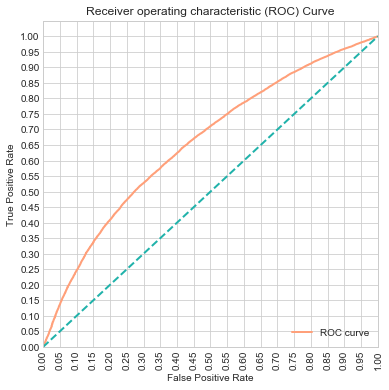

In [157]:
fpr, tpr, thresholds = roc_curve(y_test, model5_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [158]:
score_NN5 = ['NN: Dropping Features', model5_train_acc, model5_test_acc]

### Neural Network Model 6: SGD

In [159]:
model6 = models.Sequential()

model6.add(layers.Dense(12, 
                       kernel_initializer='uniform', 
                       activation='relu', 
                       input_shape=(X_train.shape[1],)))
model6.add(layers.Dense(6, 
                        kernel_regularizer=regularizers.l1(0.005),
                        activation='relu'))
model6.add(layers.Dense(6, activation='relu'))
model6.add(layers.Dense(1, activation='sigmoid'))

In [160]:
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 7         
Total params: 499
Trainable params: 499
Non-trainable params: 0
_________________________________________________________________


In [161]:
model6.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [162]:
history6 = model6.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)

Train on 171968 samples, validate on 42993 samples
Epoch 1/10
171968/171968 [==============================] - 2s 10us/step - loss: 0.7413 - acc: 0.6540 - val_loss: 0.7337 - val_acc: 0.6555
Epoch 2/10
171968/171968 [==============================] - 1s 5us/step - loss: 0.7316 - acc: 0.6546 - val_loss: 0.7278 - val_acc: 0.6555
Epoch 3/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.7258 - acc: 0.6546 - val_loss: 0.7222 - val_acc: 0.6555
Epoch 4/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.7203 - acc: 0.6546 - val_loss: 0.7168 - val_acc: 0.6555
Epoch 5/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.7149 - acc: 0.6546 - val_loss: 0.7114 - val_acc: 0.6555
Epoch 6/10
171968/171968 [==============================] - 1s 5us/step - loss: 0.7097 - acc: 0.6546 - val_loss: 0.7064 - val_acc: 0.6555
Epoch 7/10
171968/171968 [==============================] - 1s 6us/step - loss: 0.7047 - acc: 0.6546 - val_loss: 0.7015 

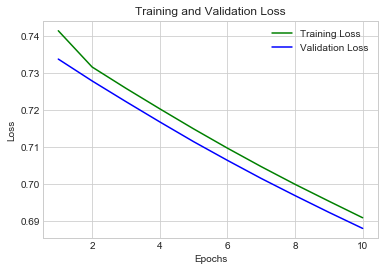

In [163]:
history_dict6 = history6.history
loss_values6 = history_dict6['loss']
val_loss_values6 = history_dict6['val_loss']

epochs6 = range(1, len(loss_values6) + 1)
plt.plot(epochs6, loss_values6, 'green', label='Training Loss')
plt.plot(epochs6, val_loss_values6, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

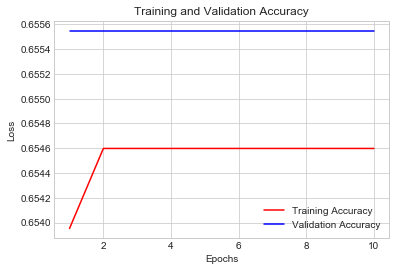

In [164]:
acc_values6 = history_dict6['acc'] 
val_acc_values6 = history_dict6['val_acc']

plt.plot(epochs6, acc_values6, 'red', label='Training Accuracy')
plt.plot(epochs6, val_acc_values6, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [165]:
model6_train_loss, model6_train_acc = model6.evaluate(X_train, y_train)
print(f'Model 6 Train Loss:      {(model6_train_loss * 100):.4}%')
print(f'Model 6 Train Accuracy:  {(model6_train_acc * 100):.4}%')

214961/214961 [==============================] - 6s 29us/step
Model 6 Train Loss:      68.86%
Model 6 Train Accuracy:  65.48%


In [166]:
model6_test_loss, model6_test_acc = model6.evaluate(X_test, y_test)
print(f'Model 6 Test Loss:      {(model6_test_loss * 100):.4}%')
print(f'Model 6 Test Accuracy:  {(model6_test_acc * 100):.4}%')

53741/53741 [==============================] - 2s 32us/step
Model 6 Test Loss:      68.78%
Model 6 Test Accuracy:  65.63%


In [167]:
model6_hat_test = model6.predict(X_test)

AUC: 0.49584


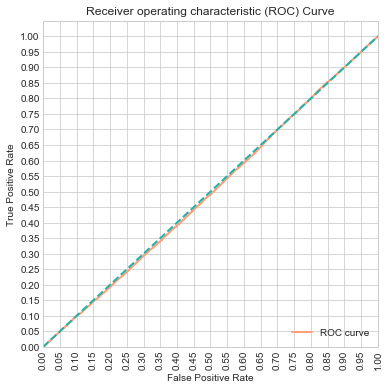

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, model6_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [169]:
score_NN6 = ['NN: SGD Optimizer', model6_train_acc, model6_test_acc]

### Neural Network Model 7: SGD With More Epochs

In [170]:
model7 = models.Sequential()

model7.add(layers.Dense(12, 
                       kernel_initializer='uniform', 
                       activation='relu', 
                       input_shape=(X_train.shape[1],)))
model7.add(layers.Dense(7, 
                        kernel_regularizer=regularizers.l1(0.005),
                        activation='relu'))
model7.add(layers.Dense(7, activation='relu'))
model7.add(layers.Dense(1, activation='sigmoid'))

In [171]:
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 7         
Total params: 499
Trainable params: 499
Non-trainable params: 0
_________________________________________________________________


In [172]:
model7.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [173]:
history7 = model7.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_split=0.2)

Train on 171968 samples, validate on 42993 samples
Epoch 1/40
171968/171968 [==============================] - 2s 9us/step - loss: 0.7739 - acc: 0.6544 - val_loss: 0.7581 - val_acc: 0.6555
Epoch 2/40
171968/171968 [==============================] - 1s 6us/step - loss: 0.7553 - acc: 0.6546 - val_loss: 0.7511 - val_acc: 0.6555
Epoch 3/40
171968/171968 [==============================] - 1s 6us/step - loss: 0.7486 - acc: 0.6546 - val_loss: 0.7446 - val_acc: 0.6555
Epoch 4/40
171968/171968 [==============================] - 1s 6us/step - loss: 0.7421 - acc: 0.6546 - val_loss: 0.7381 - val_acc: 0.6555
Epoch 5/40
171968/171968 [==============================] - 1s 6us/step - loss: 0.7357 - acc: 0.6546 - val_loss: 0.7317 - val_acc: 0.6555
Epoch 6/40
171968/171968 [==============================] - 1s 6us/step - loss: 0.7294 - acc: 0.6546 - val_loss: 0.7257 - val_acc: 0.6555
Epoch 7/40
171968/171968 [==============================] - 1s 6us/step - loss: 0.7235 - acc: 0.6546 - val_loss: 0.7198 -

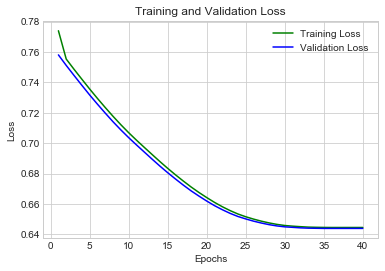

In [174]:
history_dict7 = history7.history
loss_values7 = history_dict7['loss']
val_loss_values7 = history_dict7['val_loss']

epochs7 = range(1, len(loss_values7) + 1)
plt.plot(epochs7, loss_values7, 'green', label='Training Loss')
plt.plot(epochs7, val_loss_values7, 'blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

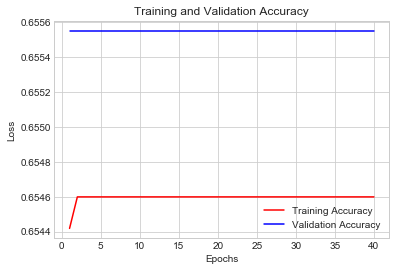

In [175]:
acc_values7 = history_dict7['acc'] 
val_acc_values7 = history_dict7['val_acc']

plt.plot(epochs7, acc_values7, 'red', label='Training Accuracy')
plt.plot(epochs7, val_acc_values7, 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [176]:
model7_train_loss, model7_train_acc = model7.evaluate(X_train, y_train)
print(f'Model 7 Train Loss:      {(model7_train_loss * 100):.4}%')
print(f'Model 7 Train Accuracy:  {(model7_train_acc * 100):.4}%')

214961/214961 [==============================] - 5s 23us/step
Model 7 Train Loss:      64.44%
Model 7 Train Accuracy:  65.48%


In [177]:
model7_test_loss, model7_test_acc = model7.evaluate(X_test, y_test)
print(f'Model 7 Test Loss:      {(model7_test_loss * 100):.4}%')
print(f'Model 7 Test Accuracy:  {(model7_test_acc * 100):.4}%')

53741/53741 [==============================] - 1s 22us/step
Model 7 Test Loss:      64.35%
Model 7 Test Accuracy:  65.63%


In [178]:
model7_hat_test = model7.predict(X_test)

AUC: 0.50251


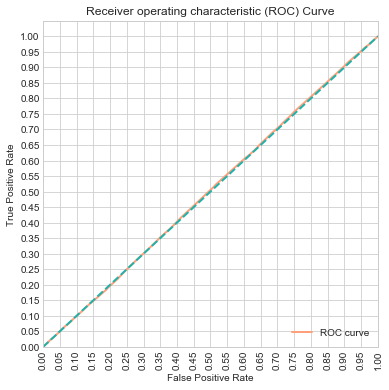

In [179]:
fpr, tpr, thresholds = roc_curve(y_test, model7_hat_test)
roc_auc = auc(fpr, tpr)

print('AUC:', round(roc_auc,5))

plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='lightsalmon',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightseagreen', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)], rotation=90)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [180]:
score_NN7 = ['NN: SGD Optimizer, Added Epochs', model7_train_acc, model7_test_acc]

## Interpretation and Conclusions

In [181]:
models = pd.DataFrame()

In [182]:
models = models.append([score_xgb, score_xgb2, score_xgb3, score_NN1, score_NN2, score_NN3, score_NN4, score_NN5, score_NN6, score_NN7])

In [183]:
models

,0,1,2
0,XGBoost,0.655389,0.655466
1,XGBoost Low Ranked Features Removed,0.676295,0.675574
2,XGBoost Location Removed,0.674411,0.673843
3,Baseline NN,0.615590,0.612329
4,NN: L1 Regularization,0.606625,0.604319
5,NN: L2 Regularization,0.665307,0.667368
6,NN: Dropout Regularization,0.654854,0.656035
7,NN: Dropping Features,0.665460,0.667144
8,NN: SGD Optimizer,0.654789,0.656296
9,"NN: SGD Optimizer, Added Epochs",0.654789,0.656296


### Comparing the Models

In [184]:
models.columns = ['Model', 'Training Accuracy', 'Testing Accuracy']
models.set_index(['Model'], inplace=True)

models

,Training Accuracy,Testing Accuracy
Model,,
XGBoost,0.655389,0.655466
XGBoost Low Ranked Features Removed,0.676295,0.675574
XGBoost Location Removed,0.674411,0.673843
Baseline NN,0.615590,0.612329
NN: L1 Regularization,0.606625,0.604319
NN: L2 Regularization,0.665307,0.667368
NN: Dropout Regularization,0.654854,0.656035
NN: Dropping Features,0.665460,0.667144
NN: SGD Optimizer,0.654789,0.656296


In [185]:
# Sorted by testing accuracy

models.sort_values(['Testing Accuracy'], ascending=False)

,Training Accuracy,Testing Accuracy
Model,,
XGBoost Low Ranked Features Removed,0.676295,0.675574
XGBoost Location Removed,0.674411,0.673843
NN: L2 Regularization,0.665307,0.667368
NN: Dropping Features,0.665460,0.667144
NN: SGD Optimizer,0.654789,0.656296
"NN: SGD Optimizer, Added Epochs",0.654789,0.656296
NN: Dropout Regularization,0.654854,0.656035
XGBoost,0.655389,0.655466
Baseline NN,0.615590,0.612329


The highest performing deep learning models ended up being the neural network model after dropping the low performing features with a test accuracy of 66.78%. The lowest performing features were determined by the XGBoost following the class balancing, and had little to no influence over the overall model performance.

The second highest performing deep learning model was the neural network model using L2 regularization, providing a testing accuracy of 66.68%. L2 regularization is also known as weight decay. This enhanced the baseline neural network model by adding the sum of the squares of all weights in the network to the cost function. This provides the network with the opportunity to learn the smaller weights that are more likely to get overlooked.

The initial XGBoost model I made gave a predictive value of 67.63% accuracy. However, I believe that model was overfit due to class imbalance of 2/3 sold as opposed to not sold results. So I used SMOTE (Synthetic Minority Over-sampling Technique) to address the class imbalance by generating synthetic data based on feature space similarities between existing instances in the minority class.

After trying different models and tuning methods, I was able to produce an XGBoost model that delivered 67.56% accuracy in predicting whether or not a home would sell. This ideal model took the XGBoost model after balancing and removed the 10 features with a weight of 0. This is the model I will use as my final model.

## Follow up EDA

In [186]:
view(df,2)

,sold,zip_code,list_price,lot_size,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,fireplace,garage,age_when_listed,flood_prone_area
0,True,77665,39900,2688.0,2.0,1.0,0.0,1.0,0,0,0,0,65,1
1,True,77554,25000,2242.8,1.0,1.0,0.0,2.0,0,0,1,1,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301003,False,77025,999000,9167.0,4.0,3.0,1.0,2.0,0,0,1,1,13,1
301004,False,77092,999900,23760.0,2.0,2.0,0.0,1.0,0,0,0,1,68,1


In [187]:
df.sold.value_counts()[1]/len(df)

0.6550900253812774

In [188]:
df[df.sold==True].describe().T

,count,mean,std,min,25%,50%,75%,max
list_price,176024.0,267907.050453,141372.864664,20000.0,175000.0,232500.0,325000.0,1000000.0
lot_size,176024.0,9743.097470,10476.041656,0.0,6036.8,7498.0,9620.0,99927.0
bedrooms,176024.0,3.478128,0.751970,1.0,3.0,3.0,4.0,5.0
baths_full,176024.0,2.275014,0.631865,1.0,2.0,2.0,3.0,4.0
baths_half,176024.0,0.505454,0.527141,0.0,0.0,0.0,1.0,2.0
stories,176024.0,1.509135,0.556760,1.0,1.0,1.0,2.0,3.5
new_construction,176024.0,0.179373,0.383666,0.0,0.0,0.0,0.0,1.0
pool_private,176024.0,0.102895,0.303823,0.0,0.0,0.0,0.0,1.0
fireplace,176024.0,0.614053,0.486820,0.0,0.0,1.0,1.0,1.0
garage,176024.0,0.923601,0.265636,0.0,1.0,1.0,1.0,1.0


In [189]:
df[df.sold==False].describe().T

,count,mean,std,min,25%,50%,75%,max
list_price,92678.0,332002.599711,170244.062235,20000.0,217000.0,295990.0,400000.0,1000000.0
lot_size,92678.0,10229.598740,11563.076677,0.0,5915.0,7800.0,10123.0,99840.0
bedrooms,92678.0,3.590734,0.798942,1.0,3.0,4.0,4.0,5.0
baths_full,92678.0,2.438303,0.700639,1.0,2.0,2.0,3.0,4.0
baths_half,92678.0,0.635135,0.528921,0.0,0.0,1.0,1.0,2.0
stories,92678.0,1.684019,0.598750,1.0,1.0,2.0,2.0,3.5
new_construction,92678.0,0.146324,0.353432,0.0,0.0,0.0,0.0,1.0
pool_private,92678.0,0.111094,0.314251,0.0,0.0,0.0,0.0,1.0
fireplace,92678.0,0.638199,0.480524,0.0,0.0,1.0,1.0,1.0
garage,92678.0,0.914791,0.279194,0.0,1.0,1.0,1.0,1.0


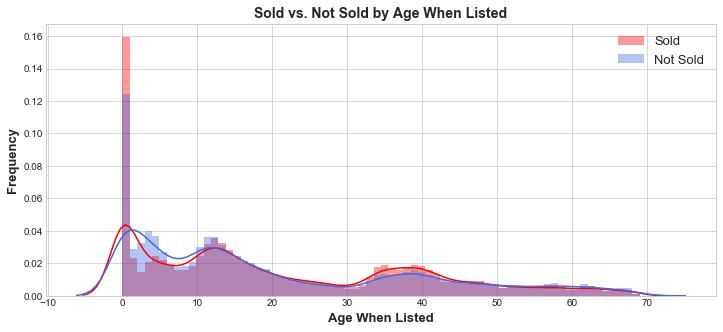

In [190]:
# Visualizing the difference sold vs. not sold for different ages when listed

plt.figure(figsize=(12,5))
sns.distplot(df[df.sold==True].age_when_listed, bins=70, label="Sold", color='red')
sns.distplot(df[df.sold==False].age_when_listed, bins=70, label="Not Sold", color='royalblue')
plt.title("Sold vs. Not Sold by Age When Listed", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Age When Listed", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

In [191]:
import statistics
 
print(statistics.mode(df.age_when_listed))

0


In [192]:
df[df.age_when_listed==0].sold.value_counts()[1]/len(df[df.age_when_listed==0])

0.7084197853428623

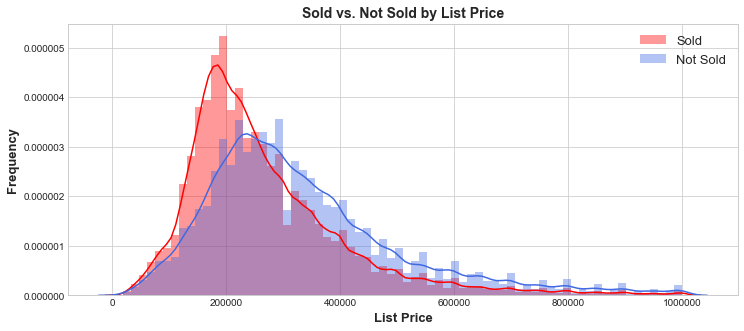

In [193]:
# Visualizing the difference sold vs. not sold for listing prices

plt.figure(figsize=(12,5))
sns.distplot(df[df.sold==True].list_price, bins=70, label="Sold", color='red')
sns.distplot(df[df.sold==False].list_price, bins=70, label="Not Sold", color='royalblue')
plt.title("Sold vs. Not Sold by List Price", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("List Price", fontsize=13, fontweight='bold')             
plt.legend(fontsize=13)
plt.show()

In [194]:
print(statistics.mode(df.list_price))

225000


In [195]:
df[df.list_price==225000].sold.value_counts()[1]/len(df[df.list_price==225000])

0.7030193780982424

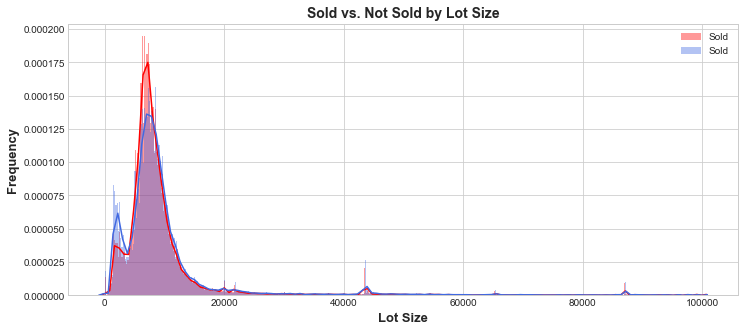

In [196]:
# Visualizing the difference sold vs. not sold for lot size

plt.figure(figsize=(12,5))
sns.distplot(df[df.sold==True].lot_size, bins=500, label="Sold", color='red')
sns.distplot(df[df.sold==False].lot_size, bins=500, label="Sold", color='royalblue')
plt.title("Sold vs. Not Sold by Lot Size", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Lot Size", fontsize=13, fontweight='bold')
plt.legend()
plt.show()

In [197]:
print(statistics.mode(df.lot_size))

6600.0


In [198]:
df[df.lot_size==6600].sold.value_counts()[1]/len(df[df.lot_size==6600])

0.7452316076294278

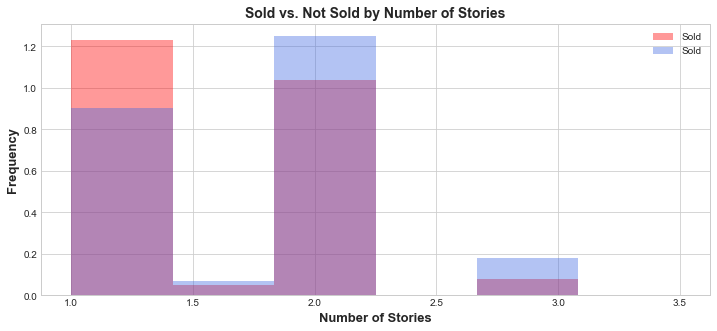

In [199]:
# Visualizing the difference sold vs. not sold for stories

plt.figure(figsize=(12,5))
sns.distplot(df[df.sold==True].stories, bins=6, label="Sold", color='red', kde=False, norm_hist=True)
sns.distplot(df[df.sold==False].stories, bins=6, label="Sold", color='royalblue', kde=False, norm_hist=True)
plt.title("Sold vs. Not Sold by Number of Stories", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=13, fontweight='bold')
plt.xlabel("Number of Stories", fontsize=13, fontweight='bold')
plt.legend()
plt.show()

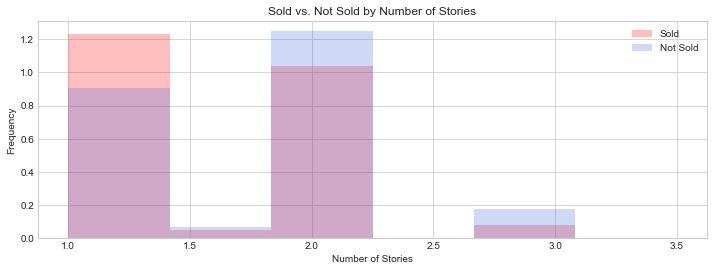

In [200]:
# Visualizing the difference sold vs. not sold for stories

plt.figure(figsize=(12,4))
plt.hist(df[df.sold==True].stories, bins=6, alpha=.25, label="Sold", density=True, color="red")
plt.hist(df[df.sold==False].stories, bins=6, alpha=.25, label="Not Sold", density=True, color="royalblue")
plt.title("Sold vs. Not Sold by Number of Stories")
plt.ylabel("Frequency")
plt.xlabel("Number of Stories")
plt.legend()
plt.show()

In [201]:
print(statistics.mode(df.stories))

1.0


In [202]:
df[df.stories==1].sold.value_counts()[1]/len(df[df.stories==1])

0.7212178345170285

In [203]:
df[df.stories==2].sold.value_counts()[1]/len(df[df.stories==2])

0.6124341496762779

In [204]:
df[df.stories==3].sold.value_counts()[1]/len(df[df.stories==3])

0.454682899657834

#### Conclusions

The biggest indicators of whether or not a home sells are:

1. **Age of home when listed:** the newer the house, the more likely it is to sell. 70.84% of newly built homes (with an age of 0 years) sold.
2. **List price:** The modal list price of the homes that sold was $225,000, with 70.3% homes listed at this price selling.
3. **Lot size:** The modal lot size of homes that sold was 6,600 sq ft, with 74.52% of homes with this lot size selling.
4. **Number of stories:** 1- story homes are more likely to sell in comparison to 2- or 3- story homes. 72% of 1-story homes sold, compared to 61% of 2-story homes and 45% of 3-story homes.

These numbers compare to an overall 65.51% of homes sold in the dataframe.

Further conclusions were made in notebook 2, where we more thoroughly explored the MLS data.

### Future Work

* Clarify - what does it mean to say that home is not sold?
* Include a broader span of data with sales preceding 2015
* Use county appraisal data to get more details on each home beyond the features provided by HAR
    * More concrete data regarding each home
    * Home appraisal value over time - can assess change over time, taking into account flooding events
    * Information on building material
* Rather than modeling the chance of a home being sold or not, make a model that predicts how long it will take a home to sell given various criteria